In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import datetime
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import timm
from torch.profiler import profile, record_function, ProfilerActivity

import config


In [2]:
if config.ADSMI:
    from DL_pretrain import ADSMI_DL_NP_petrain as DL
    Data_name = 'ADSMI'

# clear cuda cache
torch.cuda.empty_cache()

In [3]:

class ContrastiveTripletLoss(nn.Module):
    def __init__(self, margin=0.5, temperature=0.07):
        super(ContrastiveTripletLoss, self).__init__()
        self.margin = margin
        self.temperature = temperature

    def forward(self, anchor, positive, negative):
        """
        Args:
        - anchor: Embeddings from log_s_po_aug1
        - positive: Embeddings from log_s_po_aug2
        - negative: Embeddings from log_s_neg_aug1

        Returns:
        - A loss scalar.
        """
        # L2 normalize the embeddings
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)

        # Compute similarities
        pos_sim = F.cosine_similarity(anchor, positive) / self.temperature
        neg_sim = F.cosine_similarity(anchor, negative) / self.temperature

        # Compute the triplet loss
        losses = F.relu(self.margin - pos_sim + neg_sim)

        return losses.mean()

# Model with PH

In [4]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer (with 50% probability)
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()
        # Load a pre-trained EfficientNet. The last FC layer will be removed automatically.
        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer (if needed)
        #self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


In [5]:

patience = 30  # or whatever value you deem appropriate
early_stop_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(config.epochs)
print(config.batch_size)


# Initialization
#model = ContrastiveTripletModel().to(device)
model = ContrastiveTripletModelwithPH().to(device)
#model = ContrastiveTripletModelwithPHEfficient().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
criterion = ContrastiveTripletLoss()

# Data
train_loader, test_loader = DL.create_generators()



120
32


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of files:  39887
2013-10-18_15-48-26_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_15-48-26_01.WAV
Number of files:  4431
2013-10-18_16-03-42_01.WAV
Fullpath: G:/Dokumente/MAData/Unlabeled_all/2013-10-18_16-03-42_01.WAV


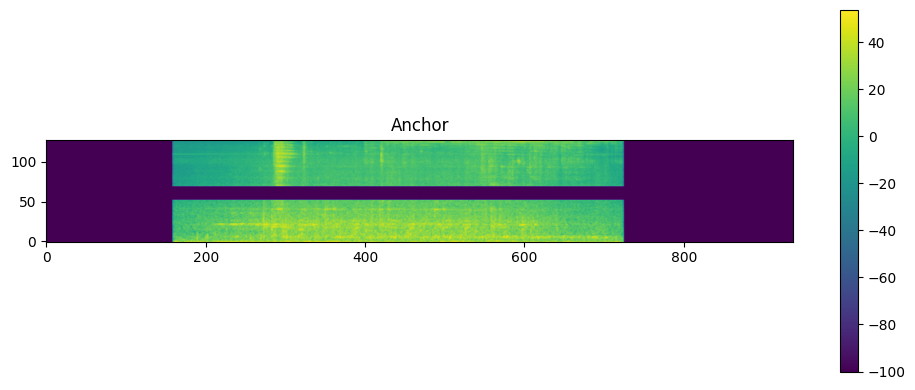

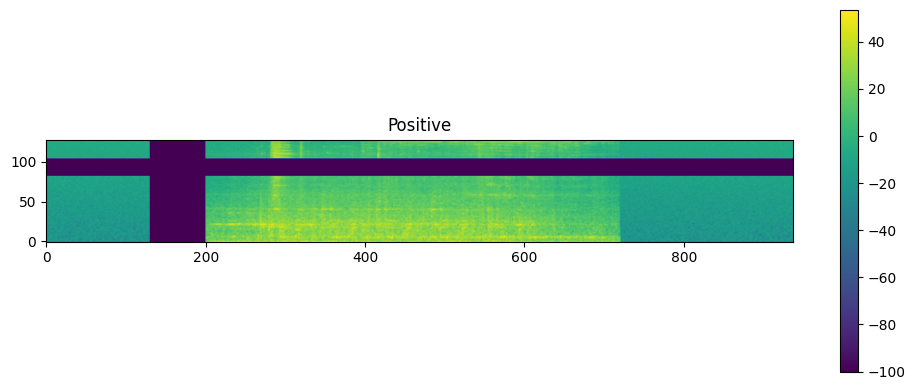

KeyboardInterrupt: 

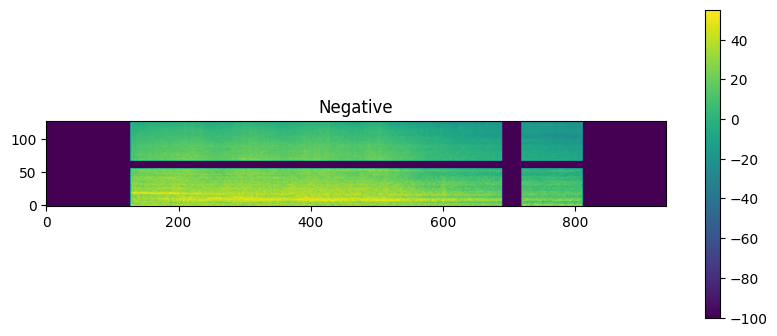

In [6]:
data1, data2, data3 = next(iter(train_loader))

#plot anchor as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data1[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Anchor')
plt.tight_layout()
plt.show()

#plot positive as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data2[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Positive')
plt.tight_layout()
plt.show()

#plot negative as melspectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data3[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Negative')
plt.tight_layout()
plt.show()



In [ ]:


epochs = config.epochs
training_losses = []
validation_losses = []


#load model
#model = torch.load('results/CLR-2023-11-08-19-epochs-300-ADSMI/checkpoint.pth')
# Create log directory
current_date = datetime.datetime.now().strftime('%Y-%m-%d-%H')
log_dir = f"./results/CLR-{current_date}-epochs-{epochs}-{Data_name}-neu_V3"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Log file path
log_file_path = os.path.join(log_dir, "training_log.txt")

#-write parameter in log file
with open(log_file_path, 'a') as log_file:
    log_file.write(f"Model: {model.__class__.__name__}\n")
    log_file.write(f"Batch size: {config.batch_size}\n")
    log_file.write(f"Learning rate: {config.lr}\n")
    log_file.write(f"Epochs: {epochs}\n")
    log_file.write(f"Patience: {patience}\n")
    log_file.write(f"Data: {Data_name}\n")
    log_file.write(f"Loss: {criterion.__class__.__name__}\n")
    log_file.write(f"Optimizer: {optimizer.__class__.__name__}\n")
    log_file.write(f"Scheduler: {lr_scheduler.__class__.__name__}\n")
    log_file.write(f"Device: {device}\n")



best_loss = float('inf')

# Training and Validation loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for batch_idx, (anchor, positive, negative) in tqdm(enumerate(train_loader), total=len(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)   
        optimizer.zero_grad()

        anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
        
        #print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
        loss = criterion(anchor_repr, positive_repr, negative_repr)
        loss.backward()

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in tqdm(enumerate(test_loader), total=len(test_loader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_repr, positive_repr, negative_repr = model(anchor, positive, negative)
            loss = criterion(anchor_repr, positive_repr, negative_repr)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Log to file
    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        print("Validation Loss improved! Checkpointing the model...")
        torch.save(model, os.path.join(log_dir, f"checkpoint.pth"))  # Modified this line
        with open(log_file_path, 'a') as log_file:
            log_file.write(f"Validation Loss improved at Epoch {epoch+1}.\n")
        early_stop_counter = 0  # reset counter
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= patience:
        print("Early stopping!")
        break

# Plot training and validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch [1/120] Training Loss: 0.4494, Validation Loss: 0.0264
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [2/120] Training Loss: 0.1633, Validation Loss: 0.0136
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [3/120] Training Loss: 0.1231, Validation Loss: 0.0074
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch [4/120] Training Loss: 0.0975, Validation Loss: 0.0046
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [5/120] Training Loss: 0.0856, Validation Loss: 0.0093


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [6/120] Training Loss: 0.0699, Validation Loss: 0.0075


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [7/120] Training Loss: 0.0674, Validation Loss: 0.0040
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [8/120] Training Loss: 0.0664, Validation Loss: 0.0053


100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch [9/120] Training Loss: 0.0629, Validation Loss: 0.0059


100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch [10/120] Training Loss: 0.0622, Validation Loss: 0.0033
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [11/120] Training Loss: 0.0624, Validation Loss: 0.0031
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch [12/120] Training Loss: 0.0556, Validation Loss: 0.0035


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [13/120] Training Loss: 0.0576, Validation Loss: 0.0034


100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch [14/120] Training Loss: 0.0549, Validation Loss: 0.0043


100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch [15/120] Training Loss: 0.0515, Validation Loss: 0.0040


100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch [16/120] Training Loss: 0.0505, Validation Loss: 0.0027
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.26it/s]


Epoch [17/120] Training Loss: 0.0493, Validation Loss: 0.0028


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [18/120] Training Loss: 0.0456, Validation Loss: 0.0029


100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch [19/120] Training Loss: 0.0446, Validation Loss: 0.0016
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [20/120] Training Loss: 0.0435, Validation Loss: 0.0018


100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch [21/120] Training Loss: 0.0412, Validation Loss: 0.0029


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [22/120] Training Loss: 0.0387, Validation Loss: 0.0030


100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch [23/120] Training Loss: 0.0381, Validation Loss: 0.0019


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [24/120] Training Loss: 0.0362, Validation Loss: 0.0021


100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch [25/120] Training Loss: 0.0368, Validation Loss: 0.0023


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [26/120] Training Loss: 0.0356, Validation Loss: 0.0034


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [27/120] Training Loss: 0.0360, Validation Loss: 0.0016
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [28/120] Training Loss: 0.0360, Validation Loss: 0.0021


100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epoch [29/120] Training Loss: 0.0356, Validation Loss: 0.0025


100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


Epoch [30/120] Training Loss: 0.0345, Validation Loss: 0.0023


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [31/120] Training Loss: 0.0332, Validation Loss: 0.0024


100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch [32/120] Training Loss: 0.0325, Validation Loss: 0.0011
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [33/120] Training Loss: 0.0334, Validation Loss: 0.0022


100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch [34/120] Training Loss: 0.0332, Validation Loss: 0.0016


100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epoch [35/120] Training Loss: 0.0310, Validation Loss: 0.0016


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [36/120] Training Loss: 0.0313, Validation Loss: 0.0025


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [37/120] Training Loss: 0.0292, Validation Loss: 0.0018


100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch [38/120] Training Loss: 0.0278, Validation Loss: 0.0020


100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


Epoch [39/120] Training Loss: 0.0294, Validation Loss: 0.0016


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [40/120] Training Loss: 0.0292, Validation Loss: 0.0015


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [41/120] Training Loss: 0.0300, Validation Loss: 0.0016


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [42/120] Training Loss: 0.0288, Validation Loss: 0.0014


100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch [43/120] Training Loss: 0.0289, Validation Loss: 0.0019


100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epoch [44/120] Training Loss: 0.0261, Validation Loss: 0.0007
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch [45/120] Training Loss: 0.0253, Validation Loss: 0.0013


100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch [46/120] Training Loss: 0.0268, Validation Loss: 0.0020


100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch [47/120] Training Loss: 0.0259, Validation Loss: 0.0005
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch [48/120] Training Loss: 0.0281, Validation Loss: 0.0010


100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch [49/120] Training Loss: 0.0242, Validation Loss: 0.0018


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [50/120] Training Loss: 0.0253, Validation Loss: 0.0012


100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch [51/120] Training Loss: 0.0276, Validation Loss: 0.0005
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch [52/120] Training Loss: 0.0251, Validation Loss: 0.0011


100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch [53/120] Training Loss: 0.0257, Validation Loss: 0.0013


100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epoch [54/120] Training Loss: 0.0251, Validation Loss: 0.0015


100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch [55/120] Training Loss: 0.0247, Validation Loss: 0.0007


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [56/120] Training Loss: 0.0263, Validation Loss: 0.0010


100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch [57/120] Training Loss: 0.0240, Validation Loss: 0.0012


100%|██████████| 139/139 [00:44<00:00,  3.13it/s]


Epoch [58/120] Training Loss: 0.0231, Validation Loss: 0.0010


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [59/120] Training Loss: 0.0229, Validation Loss: 0.0013


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [60/120] Training Loss: 0.0228, Validation Loss: 0.0004
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:45<00:00,  3.09it/s]


Epoch [61/120] Training Loss: 0.0215, Validation Loss: 0.0005


100%|██████████| 139/139 [00:44<00:00,  3.10it/s]


Epoch [62/120] Training Loss: 0.0246, Validation Loss: 0.0009


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [63/120] Training Loss: 0.0227, Validation Loss: 0.0005


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [64/120] Training Loss: 0.0219, Validation Loss: 0.0013


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [65/120] Training Loss: 0.0221, Validation Loss: 0.0007


100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch [66/120] Training Loss: 0.0211, Validation Loss: 0.0010


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [67/120] Training Loss: 0.0198, Validation Loss: 0.0007


100%|██████████| 139/139 [00:51<00:00,  2.71it/s]


Epoch [68/120] Training Loss: 0.0210, Validation Loss: 0.0006


100%|██████████| 139/139 [00:44<00:00,  3.09it/s]


Epoch [69/120] Training Loss: 0.0204, Validation Loss: 0.0017


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [70/120] Training Loss: 0.0234, Validation Loss: 0.0009


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [71/120] Training Loss: 0.0198, Validation Loss: 0.0003
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.23it/s]


Epoch [72/120] Training Loss: 0.0195, Validation Loss: 0.0003
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [73/120] Training Loss: 0.0203, Validation Loss: 0.0005


100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch [74/120] Training Loss: 0.0198, Validation Loss: 0.0003


100%|██████████| 139/139 [00:42<00:00,  3.24it/s]


Epoch [75/120] Training Loss: 0.0186, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [76/120] Training Loss: 0.0206, Validation Loss: 0.0002
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [77/120] Training Loss: 0.0194, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [78/120] Training Loss: 0.0172, Validation Loss: 0.0009


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [79/120] Training Loss: 0.0215, Validation Loss: 0.0005


100%|██████████| 139/139 [00:42<00:00,  3.24it/s]


Epoch [80/120] Training Loss: 0.0187, Validation Loss: 0.0010


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [81/120] Training Loss: 0.0190, Validation Loss: 0.0005


100%|██████████| 139/139 [00:43<00:00,  3.23it/s]


Epoch [82/120] Training Loss: 0.0198, Validation Loss: 0.0008


100%|██████████| 139/139 [00:44<00:00,  3.11it/s]


Epoch [83/120] Training Loss: 0.0171, Validation Loss: 0.0005


100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch [84/120] Training Loss: 0.0187, Validation Loss: 0.0012


100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch [85/120] Training Loss: 0.0185, Validation Loss: 0.0007


100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch [86/120] Training Loss: 0.0182, Validation Loss: 0.0012


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [87/120] Training Loss: 0.0174, Validation Loss: 0.0009


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [88/120] Training Loss: 0.0165, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.20it/s]


Epoch [89/120] Training Loss: 0.0179, Validation Loss: 0.0012


100%|██████████| 139/139 [00:44<00:00,  3.10it/s]


Epoch [90/120] Training Loss: 0.0184, Validation Loss: 0.0007


100%|██████████| 139/139 [00:44<00:00,  3.11it/s]


Epoch [91/120] Training Loss: 0.0187, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [92/120] Training Loss: 0.0184, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.19it/s]


Epoch [93/120] Training Loss: 0.0181, Validation Loss: 0.0009


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [94/120] Training Loss: 0.0177, Validation Loss: 0.0008


100%|██████████| 139/139 [00:44<00:00,  3.16it/s]


Epoch [95/120] Training Loss: 0.0199, Validation Loss: 0.0008


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [96/120] Training Loss: 0.0186, Validation Loss: 0.0006


100%|██████████| 139/139 [00:44<00:00,  3.13it/s]


Epoch [97/120] Training Loss: 0.0164, Validation Loss: 0.0007


100%|██████████| 139/139 [00:44<00:00,  3.13it/s]


Epoch [98/120] Training Loss: 0.0168, Validation Loss: 0.0004


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [99/120] Training Loss: 0.0158, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [100/120] Training Loss: 0.0172, Validation Loss: 0.0007


100%|██████████| 139/139 [00:43<00:00,  3.22it/s]


Epoch [101/120] Training Loss: 0.0187, Validation Loss: 0.0001
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:43<00:00,  3.21it/s]


Epoch [102/120] Training Loss: 0.0166, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.16it/s]


Epoch [103/120] Training Loss: 0.0175, Validation Loss: 0.0003


100%|██████████| 139/139 [00:44<00:00,  3.14it/s]


Epoch [104/120] Training Loss: 0.0160, Validation Loss: 0.0004


100%|██████████| 139/139 [00:44<00:00,  3.12it/s]


Epoch [105/120] Training Loss: 0.0165, Validation Loss: 0.0005


100%|██████████| 139/139 [00:43<00:00,  3.17it/s]


Epoch [106/120] Training Loss: 0.0164, Validation Loss: 0.0003


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [107/120] Training Loss: 0.0174, Validation Loss: 0.0002


100%|██████████| 139/139 [00:43<00:00,  3.18it/s]


Epoch [108/120] Training Loss: 0.0181, Validation Loss: 0.0001


100%|██████████| 139/139 [00:44<00:00,  3.11it/s]


Epoch [109/120] Training Loss: 0.0170, Validation Loss: 0.0009


100%|██████████| 139/139 [00:44<00:00,  3.15it/s]


Epoch [110/120] Training Loss: 0.0148, Validation Loss: 0.0002


100%|██████████| 139/139 [00:45<00:00,  3.06it/s]


Epoch [111/120] Training Loss: 0.0153, Validation Loss: 0.0005


100%|██████████| 139/139 [00:43<00:00,  3.23it/s]


Epoch [112/120] Training Loss: 0.0158, Validation Loss: 0.0002


100%|██████████| 139/139 [00:49<00:00,  2.83it/s]


Epoch [113/120] Training Loss: 0.0166, Validation Loss: 0.0006


100%|██████████| 139/139 [00:47<00:00,  2.92it/s]


Epoch [114/120] Training Loss: 0.0168, Validation Loss: 0.0000
Validation Loss improved! Checkpointing the model...


100%|██████████| 139/139 [00:45<00:00,  3.07it/s]


Epoch [115/120] Training Loss: 0.0165, Validation Loss: 0.0002


 85%|████████▍ | 1058/1247 [09:05<01:37,  1.94it/s]


KeyboardInterrupt: 

In [ ]:
#spath = './results/CLR-2023-11-08-21-epochs-300-ADSMI/checkpoint_fullModel.pth'
#torch.save(model, spath)  

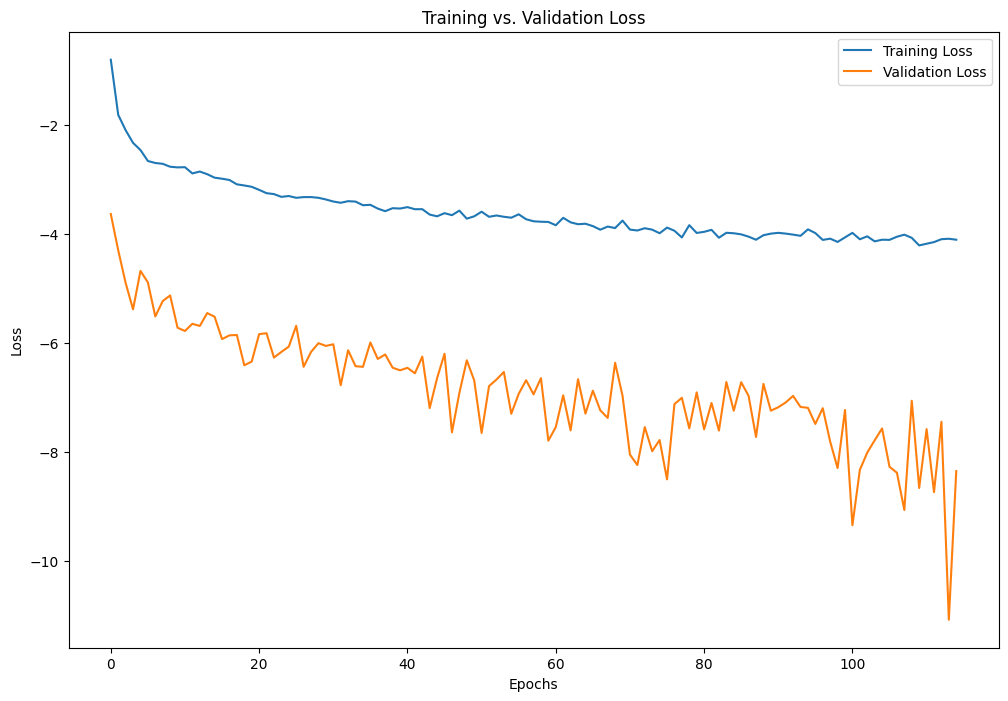

In [ ]:
#plot train and validation loss
#logarithm the two losses
training_lossesl = np.log(training_losses)
validation_lossesl = np.log(validation_losses)



plt.figure(figsize=(12, 8))
plt.plot(training_lossesl, label='Training Loss')
plt.plot(validation_lossesl, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


